In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import stat
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

In [2]:
# Evaluate model for other healthcare buildings

In [3]:
bmd = pd.read_csv('building_metadata.csv')
hlth = bmd[bmd['primary_use']=='Healthcare']
hlth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 208 to 1388
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      23 non-null     int64  
 1   building_id  23 non-null     int64  
 2   primary_use  23 non-null     object 
 3   square_feet  23 non-null     int64  
 4   year_built   8 non-null      float64
 5   floor_count  1 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.3+ KB


In [4]:
hlth

,site_id,building_id,primary_use,square_feet,year_built,floor_count
208,2,208,Healthcare,36904,1934.0,NaN
365,3,365,Healthcare,819577,1922.0,NaN
455,3,455,Healthcare,29192,2014.0,NaN
535,3,535,Healthcare,15000,2010.0,NaN
547,3,547,Healthcare,23903,NaN,NaN
548,3,548,Healthcare,9813,2010.0,NaN
556,3,556,Healthcare,450000,2012.0,NaN
670,5,670,Healthcare,18471,1966.0,1.0
1072,13,1072,Healthcare,305000,NaN,NaN
1207,13,1207,Healthcare,74443,NaN,NaN


In [5]:
hlth_bld_id_list = hlth['building_id'].tolist()

In [6]:
# List of all healtcare buildings
hlth_bld_id_list

[208,
 365,
 455,
 535,
 547,
 548,
 556,
 670,
 1072,
 1207,
 1208,
 1209,
 1241,
 1243,
 1245,
 1269,
 1282,
 1285,
 1286,
 1300,
 1303,
 1313,
 1388]

In [7]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
full_df = pd.read_csv('train.csv',index_col='timestamp',parse_dates=True, infer_datetime_format=True)

In [9]:
full_df = reduce_mem_usage(full_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [10]:
#Chooosing only electricty
full_df = full_df[full_df['meter']==0]

In [11]:
health_df_full = full_df[full_df.building_id.isin(hlth_bld_id_list)]

In [12]:
health_df_full

,building_id,meter,meter_reading
timestamp,,,
2016-01-01 00:00:00,208,0,77.290001
2016-01-01 00:00:00,365,0,1139.520020
2016-01-01 00:00:00,455,0,10.600000
2016-01-01 00:00:00,535,0,22.459999
2016-01-01 00:00:00,547,0,21.889999
...,...,...,...
2016-12-31 23:00:00,1285,0,193.000000
2016-12-31 23:00:00,1286,0,370.320007
2016-12-31 23:00:00,1300,0,49.509102


In [13]:
health_df_full = health_df_full.drop('meter', axis = 1)

In [14]:
health_df_full.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=184345, freq=None)

In [15]:
# Making a huge pivot table -> columns are each leathcare building
health_df_piv = pd.pivot_table(health_df_full, index=health_df_full.index, columns='building_id')

In [16]:
health_df_piv

meter_reading                                     \
building_id                  208          365        455        535    
timestamp                                                              
2016-01-01 00:00:00     77.290001  1139.520020  10.600000  22.459999   
2016-01-01 01:00:00     87.089996  1122.719971   9.770000  22.120001   
2016-01-01 02:00:00     90.510002  1096.800049  10.120000  23.440001   
2016-01-01 03:00:00     83.660004  1098.959961   9.580000  26.150000   
2016-01-01 04:00:00     89.550003  1105.920044  10.250000  26.400000   
...                           ...          ...        ...        ...   
2016-12-31 19:00:00     38.230000  1270.319946  60.689999  45.349998   
2016-12-31 20:00:00     39.459999  1281.359985  60.509998  47.139999   
2016-12-31 21:00:00     28.350000  1296.239990  59.799999  45.520000   
2016-12-31 22:00:00     27.309999  1291.439941  60.029999  45.840000   
2016-12-31 23:00:00     27.639999  1277.760010  62.180000  46.759998   

                                                                      \
building_id               547    548          556   670         1207   
timestamp                                                              
2016-01-01 00:00:00  21.889999   8.97  1013.780029   8.0  150.557007   
2016-01-01 01:00:00  24.110001   9.49   988.380005  14.9  150.557007   
2016-01-01 02:00:00  23.990000   9.52   996.250000  11.2  151.167007   
2016-01-01 03:00:00  23.950001   9.04   966.219971  11.4  150.645004   
2016-01-01 04:00:00  24.219999   9.72   984.390015  11.0  150.811005   
...                        ...    ...          ...   ...         ...   
2016-12-31 19:00:00  31.330000  19.27  1225.359985  16.0  165.285995   
2016-12-31 20:00:00  32.380001  18.84  1178.640015  16.0  166.059998   
2016-12-31 21:00:00  31.620001  19.00  1187.449951  16.0  165.654007   
2016-12-31 22:00:00  32.570000  20.49  1159.839966  14.6  163.789001   
2016-12-31 23:00:00  32.000000  18.99  1156.589966  11.3  163.723999   

                                 ...                                   \
building_id                1208  ...        1241        1243     1245   
timestamp                        ...                                    
2016-01-01 00:00:00  186.531998  ...  234.179993  132.992996  25.4375   
2016-01-01 01:00:00  186.531998  ...  294.156006  162.729996  24.0312   
2016-01-01 02:00:00  183.479004  ...  354.152008  126.353996  25.7188   
2016-01-01 03:00:00  184.302994  ...  294.121002  155.309998  22.2188   
2016-01-01 04:00:00  183.656998  ...  294.101990  113.105003  21.8125   
...                         ...  ...         ...         ...      ...   
2016-12-31 19:00:00  191.494995  ...  262.000000  163.959000  20.0625   
2016-12-31 20:00:00  188.776993  ...  252.000000  159.632004  23.0312   
2016-12-31 21:00:00  189.929993  ...  252.000000  167.992004  21.1250   
2016-12-31 22:00:00  186.824997  ...  257.000000  167.076004  23.8750   
2016-12-31 23:00:00  186.628006  ...  260.000000  159.804001  25.1562   

                                                                     \
building_id               1269   1282   1285        1286       1300   
timestamp                                                             
2016-01-01 00:00:00  20.066200  537.0  198.0  338.109985  53.085499   
2016-01-01 01:00:00  21.890301  512.0  227.0  324.510010  49.849701   
2016-01-01 02:00:00  19.709000  541.0  209.0  323.820007  51.382500   
2016-01-01 03:00:00  20.181700  522.0  199.0  318.720001  50.299801   
2016-01-01 04:00:00  22.221500  531.0  177.0  314.950012  51.066200   
...                        ...    ...    ...         ...        ...   
2016-12-31 19:00:00  29.116400  546.0  194.0  373.799988  56.260399   
2016-12-31 20:00:00  29.281200  537.0  195.0  367.019989  52.562401   
2016-12-31 21:00:00  30.658199  536.0  218.0  376.089996  53.851799   
2016-12-31 22:00:00  29.225700  534.0  198.0  366.230011  52.051498   
2016-12-31 23:00:00  27.266100  526.0  193.0  370.320007

In [17]:
health_df_piv.columns

MultiIndex([('meter_reading',  208),
            ('meter_reading',  365),
            ('meter_reading',  455),
            ('meter_reading',  535),
            ('meter_reading',  547),
            ('meter_reading',  548),
            ('meter_reading',  556),
            ('meter_reading',  670),
            ('meter_reading', 1207),
            ('meter_reading', 1208),
            ('meter_reading', 1209),
            ('meter_reading', 1241),
            ('meter_reading', 1243),
            ('meter_reading', 1245),
            ('meter_reading', 1269),
            ('meter_reading', 1282),
            ('meter_reading', 1285),
            ('meter_reading', 1286),
            ('meter_reading', 1300),
            ('meter_reading', 1303),
            ('meter_reading', 1313)],
           names=[None, 'building_id'])

In [18]:
health_df_piv = health_df_piv.resample('H').backfill()

In [19]:
health_df_piv.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8784, freq='H')

In [20]:
np.isinf(health_df_piv.all()).sum()

0

In [21]:
np.isnan(health_df_piv.all()).sum()

0

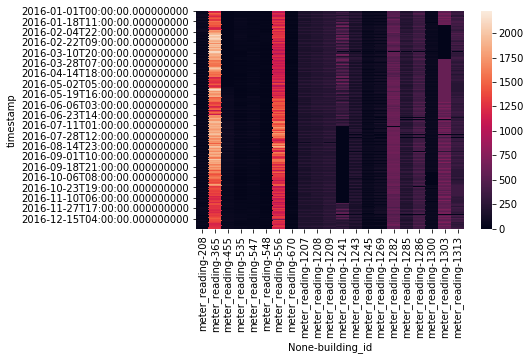

In [22]:
sns.heatmap(health_df_piv)

In [23]:
#Pretty massive variation in energy usage by building...
# As we knew before, 556 and 365 have much higher energy consumptions
# May have to make separate model for these

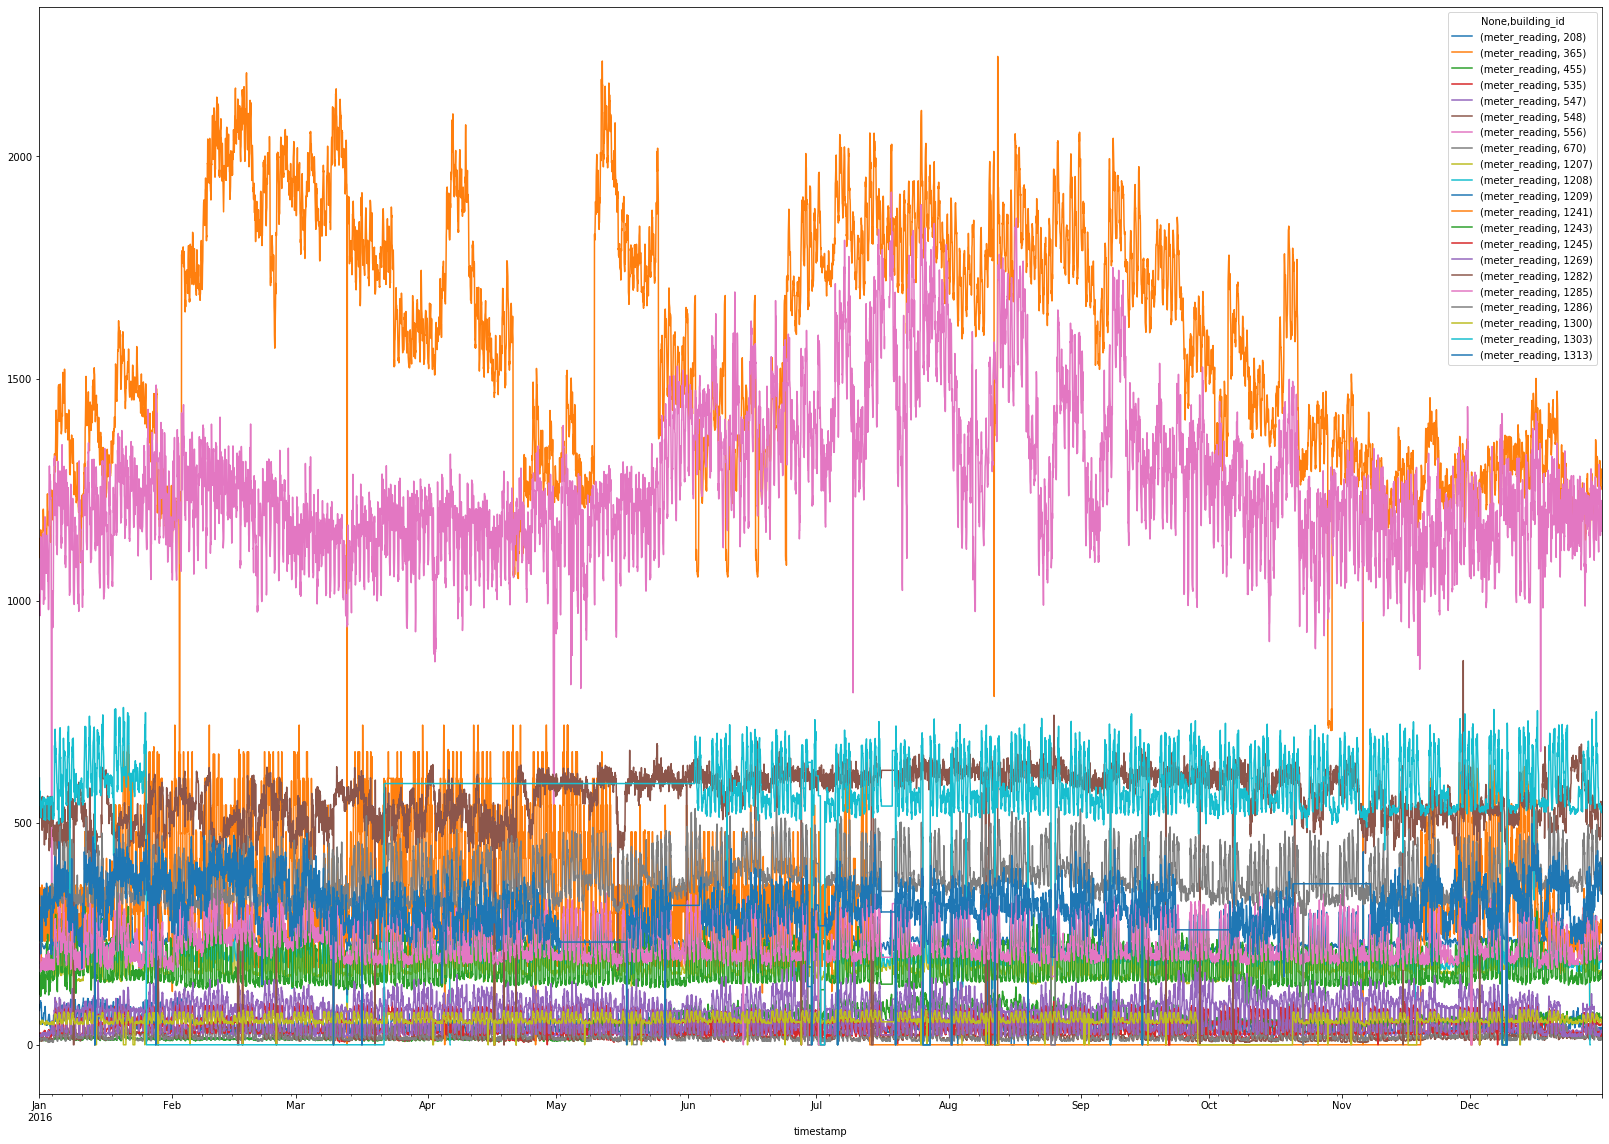

In [24]:
health_df_piv.plot(figsize=(28,20))

In [25]:
#sns.pairplot(health_df_piv['meter_reading'])

In [26]:
# Sorting buildings by size
hlth.sort_values(by=['square_feet'],ascending=True)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
548,3,548,Healthcare,9813,2010.0,NaN
1282,14,1282,Healthcare,12500,NaN,NaN
535,3,535,Healthcare,15000,2010.0,NaN
670,5,670,Healthcare,18471,1966.0,1.0
547,3,547,Healthcare,23903,NaN,NaN
1300,14,1300,Healthcare,25609,NaN,NaN
455,3,455,Healthcare,29192,2014.0,NaN
1245,14,1245,Healthcare,35354,NaN,NaN
208,2,208,Healthcare,36904,1934.0,NaN
1388,15,1388,Healthcare,45465,1990.0,NaN


In [27]:
# 23 bulidings -> 7 plots of 3 data sets (and 2 spare)

In [28]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [29]:
adf_test(health_df_piv['meter_reading'][455])

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.458701
p-value                    0.125849
# lags used               31.000000
# observations          8750.000000
critical value (1%)       -3.431098
critical value (5%)       -2.861870
critical value (10%)      -2.566946
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [30]:
# Delete this as is non-stationary

In [31]:
health_df_stat.fillna(method='ffill', inplace = True)

NameError: name 'health_df_stat' is not defined

In [262]:
health_df_stat = health_df_piv.drop(columns = [455], level = 1)

In [263]:
health_df_stat.columns

MultiIndex([('meter_reading',  208),
            ('meter_reading',  365),
            ('meter_reading',  535),
            ('meter_reading',  547),
            ('meter_reading',  548),
            ('meter_reading',  556),
            ('meter_reading',  670),
            ('meter_reading', 1207),
            ('meter_reading', 1208),
            ('meter_reading', 1209),
            ('meter_reading', 1241),
            ('meter_reading', 1243),
            ('meter_reading', 1245),
            ('meter_reading', 1269),
            ('meter_reading', 1282),
            ('meter_reading', 1285),
            ('meter_reading', 1286),
            ('meter_reading', 1300),
            ('meter_reading', 1303),
            ('meter_reading', 1313)],
           names=[None, 'building_id'])

In [264]:
health_df_stat.columns = health_df_stat.columns.droplevel() # drop a level -> faster querying

In [266]:
health_df_stat.head()

building_id,208,365,535,547,548,556,670,1207,1208,1209,1241,1243,1245,1269,1282,1285,1286,1300,1303,1313
timestamp,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,77.290001,1139.520020,22.459999,21.889999,8.97,1013.780029,8.0,150.557007,186.531998,219.270004,234.179993,132.992996,25.4375,20.066200,537.0,198.0,338.109985,53.085499,600.554016,235.529999
2016-01-01 01:00:00,87.089996,1122.719971,22.120001,24.110001,9.49,988.380005,14.9,150.557007,186.531998,219.270004,294.156006,162.729996,24.0312,21.890301,512.0,227.0,324.510010,49.849701,539.424011,272.709991
2016-01-01 02:00:00,90.510002,1096.800049,23.440001,23.990000,9.52,996.250000,11.2,151.167007,183.479004,218.348007,354.152008,126.353996,25.7188,19.709000,541.0,209.0,323.820007,51.382500,564.181030,251.740005
2016-01-01 03:00:00,83.660004,1098.959961,26.150000,23.950001,9.04,966.219971,11.4,150.645004,184.302994,220.003006,294.121002,155.309998,22.2188,20.181700,522.0,199.0,318.720001,50.299801,555.093018,279.549988
2016-01-01 04:00:00,89.550003,1105.920044,26.400000,24.219999,9.72,984.390015,11.0,150.811005,183.656998,217.731003,294.101990,113.105003,21.8125,22.221500,531.0,177.0,314.950012,51.066200,570.804016,236.369995


In [267]:
nobs=730 # Hours ina  month
train, test = health_df_stat[0:-nobs], health_df_stat[-nobs:]
print(train.shape)
print(test.shape)

(8054, 20)
(730, 20)


In [ ]:
# Fot VARMA 3,2 model
model = VARMAX(train, order=(3,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

/Users/kieranodonnell/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [220]:
# All stationary except for 455

In [221]:
#Not stationary data set!

In [222]:
# all buildings have differnt data usage

# Normlize them

In [223]:
from sklearn import preprocessing

health_vals = health_df_piv['meter_reading'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
health_scaled = min_max_scaler.fit_transform(health_vals)
df_transform = pd.DataFrame(health_scaled)

In [156]:
df_transform.columns = health_df_piv.columns

In [157]:
df_transform.index = health_df_piv.index

In [158]:
df_transform.head()

meter_reading                                          \
building_id                  208       365       455       535       547    
timestamp                                                                   
2016-01-01 00:00:00      0.736095  0.512079  0.024625  0.266682  0.087732   
2016-01-01 01:00:00      0.829429  0.504530  0.017857  0.262645  0.113945   
2016-01-01 02:00:00      0.862000  0.492882  0.020711  0.278319  0.112528   
2016-01-01 03:00:00      0.796762  0.493852  0.016308  0.310496  0.112056   
2016-01-01 04:00:00      0.852857  0.496980  0.021771  0.313465  0.115244   

                                                                       ...  \
building_id              548       556       670       1207      1208  ...   
timestamp                                                              ...   
2016-01-01 00:00:00  0.069231  0.421443  0.154549  0.439394  0.600094  ...   
2016-01-01 01:00:00  0.078987  0.405221  0.293444  0.439394  0.600094  ...   
2016-01-01 02:00:00  0.079550  0.410247  0.218964  0.441174  0.590272  ...   
2016-01-01 03:00:00  0.070544  0.391069  0.222990  0.439651  0.592923  ...   
2016-01-01 04:00:00  0.083302  0.402673  0.214938  0.440135  0.590845  ...   

                                                                       \
building_id              1241      1243      1245      1269      1282   
timestamp                                                               
2016-01-01 00:00:00  0.325328  0.420458  0.253503  0.094034  0.620809   
2016-01-01 01:00:00  0.408648  0.514472  0.239488  0.102582  0.591908   
2016-01-01 02:00:00  0.491995  0.399469  0.256306  0.092360  0.625434   
2016-01-01 03:00:00  0.408599  0.491013  0.221426  0.094575  0.603468   
2016-01-01 04:00:00  0.408573  0.357582  0.217377  0.104134  0.613873   

                                                                       
building_id              1285      1286      1300      1303      1313  
timestamp                                                              
2016-01-01 00:00:00  0.496241  0.596030  0.656142  0.790844  0.473256  
2016-01-01 01:00:00  0.568922  0.572056  0.616147  0.710344  0.547963  
2016-01-01 02:00:00  0.523809  0.570839  0.635093  0.742946  0.505827  
2016-01-01 03:00:00  0.498747  0.561849  0.621710  0.730978  0.561706  
2016-01-01 04:00:00  0.443609  0.555203  0.631183  0.751667  0.474944  

[5 rows x 21 columns]

In [159]:
df_transform.isna().sum()

               building_id
meter_reading  208            22
               365             0
               455             2
               535            26
               547             2
               548            26
               556            27
               670             0
               1207            6
               1208            3
               1209            4
               1241            1
               1243            0
               1245            0
               1269            0
               1282            0
               1285            0
               1286            0
               1300            0
               1303            0
               1313            0
dtype: int64

In [160]:
df_transform.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

meter_reading                                          \
building_id                  208       365       455       535       547    
timestamp                                                                   
2016-01-01 00:00:00      0.736095  0.512079  0.024625  0.266682  0.087732   
2016-01-01 01:00:00      0.829429  0.504530  0.017857  0.262645  0.113945   
2016-01-01 02:00:00      0.862000  0.492882  0.020711  0.278319  0.112528   
2016-01-01 03:00:00      0.796762  0.493852  0.016308  0.310496  0.112056   
2016-01-01 04:00:00      0.852857  0.496980  0.021771  0.313465  0.115244   
...                           ...       ...       ...       ...       ...   
2016-12-31 19:00:00      0.364095  0.570858  0.433056  0.538471  0.199197   
2016-12-31 20:00:00      0.375810  0.575820  0.431588  0.559725  0.211595   
2016-12-31 21:00:00      0.270000  0.582506  0.425799  0.540489  0.202621   
2016-12-31 22:00:00      0.260095  0.580349  0.427674  0.544289  0.213839   
2016-12-31 23:00:00      0.263238  0.574202  0.445205  0.555212  0.207108   

                                                                       ...  \
building_id              548       556       670       1207      1208  ...   
timestamp                                                              ...   
2016-01-01 00:00:00  0.069231  0.421443  0.154549  0.439394  0.600094  ...   
2016-01-01 01:00:00  0.078987  0.405221  0.293444  0.439394  0.600094  ...   
2016-01-01 02:00:00  0.079550  0.410247  0.218964  0.441174  0.590272  ...   
2016-01-01 03:00:00  0.070544  0.391069  0.222990  0.439651  0.592923  ...   
2016-01-01 04:00:00  0.083302  0.402673  0.214938  0.440135  0.590845  ...   
...                       ...       ...       ...       ...       ...  ...   
2016-12-31 19:00:00  0.262477  0.556563  0.315587  0.482380  0.616060  ...   
2016-12-31 20:00:00  0.254409  0.526727  0.315587  0.484639  0.607316  ...   
2016-12-31 21:00:00  0.257411  0.532353  0.315587  0.483454  0.611026  ...   
2016-12-31 22:00:00  0.285366  0.514720  0.287405  0.478011  0.601036  ...   
2016-12-31 23:00:00  0.257223  0.512645  0.220977  0.477821  0.600403  ...   

                                                                       \
building_id              1241      1243      1245      1269      1282   
timestamp                                                               
2016-01-01 00:00:00  0.325328  0.420458  0.253503  0.094034  0.620809   
2016-01-01 01:00:00  0.408648  0.514472  0.239488  0.102582  0.591908   
2016-01-01 02:00:00  0.491995  0.399469  0.256306  0.092360  0.625434   
2016-01-01 03:00:00  0.408599  0.491013  0.221426  0.094575  0.603468   
2016-01-01 04:00:00  0.408573  0.357582  0.217377  0.104134  0.613873   
...                       ...       ...       ...       ...       ...   
2016-12-31 19:00:00  0.363976  0.518357  0.199937  0.136445  0.631214   
2016-12-31 20:00:00  0.350084  0.504677  0.229522  0.137217  0.620809   
2016-12-31 21:00:00  0.350084  0.531108  0.210526  0.143670  0.619653   
2016-12-31 22:00:00  0.357030  0.528212  0.237932  0.136957  0.617341   
2016-12-31 23:00:00  0.361197  0.505221  0.250700  0.127774  0.608092   

                                                                       
building_id              1285      1286      1300      1303      1313  
timestamp                                                              
2016-01-01 00:00:00  0.496241  0.596030  0.656142  0.790844  0.473256  
2016-01-01 01:00:00  0.568922  0.572056  0.616147  0.710344  0.547963  
2016-01-01 02:00:00  0.523809  0.570839  0.635093  0.742946  0.505827  
2016-01-01 03:00:00  0.498747  0.561849  0.621710  0.730978  0.561706  
2016-01-01 04:00:00  0.443609  0.555203  0.631183  0.751667  0.474944  
...                       ...       ...       ...       ...       ...  
2016-12-31 19:00:00  0.486216  0.658945  0.695384  0.702273  0.698401  
2016-12-31 20:00:00  0.488722  0.646993  0.649676  0.697143  0.692312  
2016-12-31 21:00:00  0.546366  0.

In [161]:
df_transform.isna().sum()

               building_id
meter_reading  208            22
               365             0
               455             2
               535            26
               547             2
               548            26
               556            27
               670             0
               1207            6
               1208            3
               1209            4
               1241            1
               1243            0
               1245            0
               1269            0
               1282            0
               1285            0
               1286            0
               1300            0
               1303            0
               1313            0
dtype: int64

In [162]:
df_transform.fillna(method='ffill', inplace = True)

In [163]:
df_transform.isna().sum()

               building_id
meter_reading  208            0
               365            0
               455            0
               535            0
               547            0
               548            0
               556            0
               670            0
               1207           0
               1208           0
               1209           0
               1241           0
               1243           0
               1245           0
               1269           0
               1282           0
               1285           0
               1286           0
               1300           0
               1303           0
               1313           0
dtype: int64

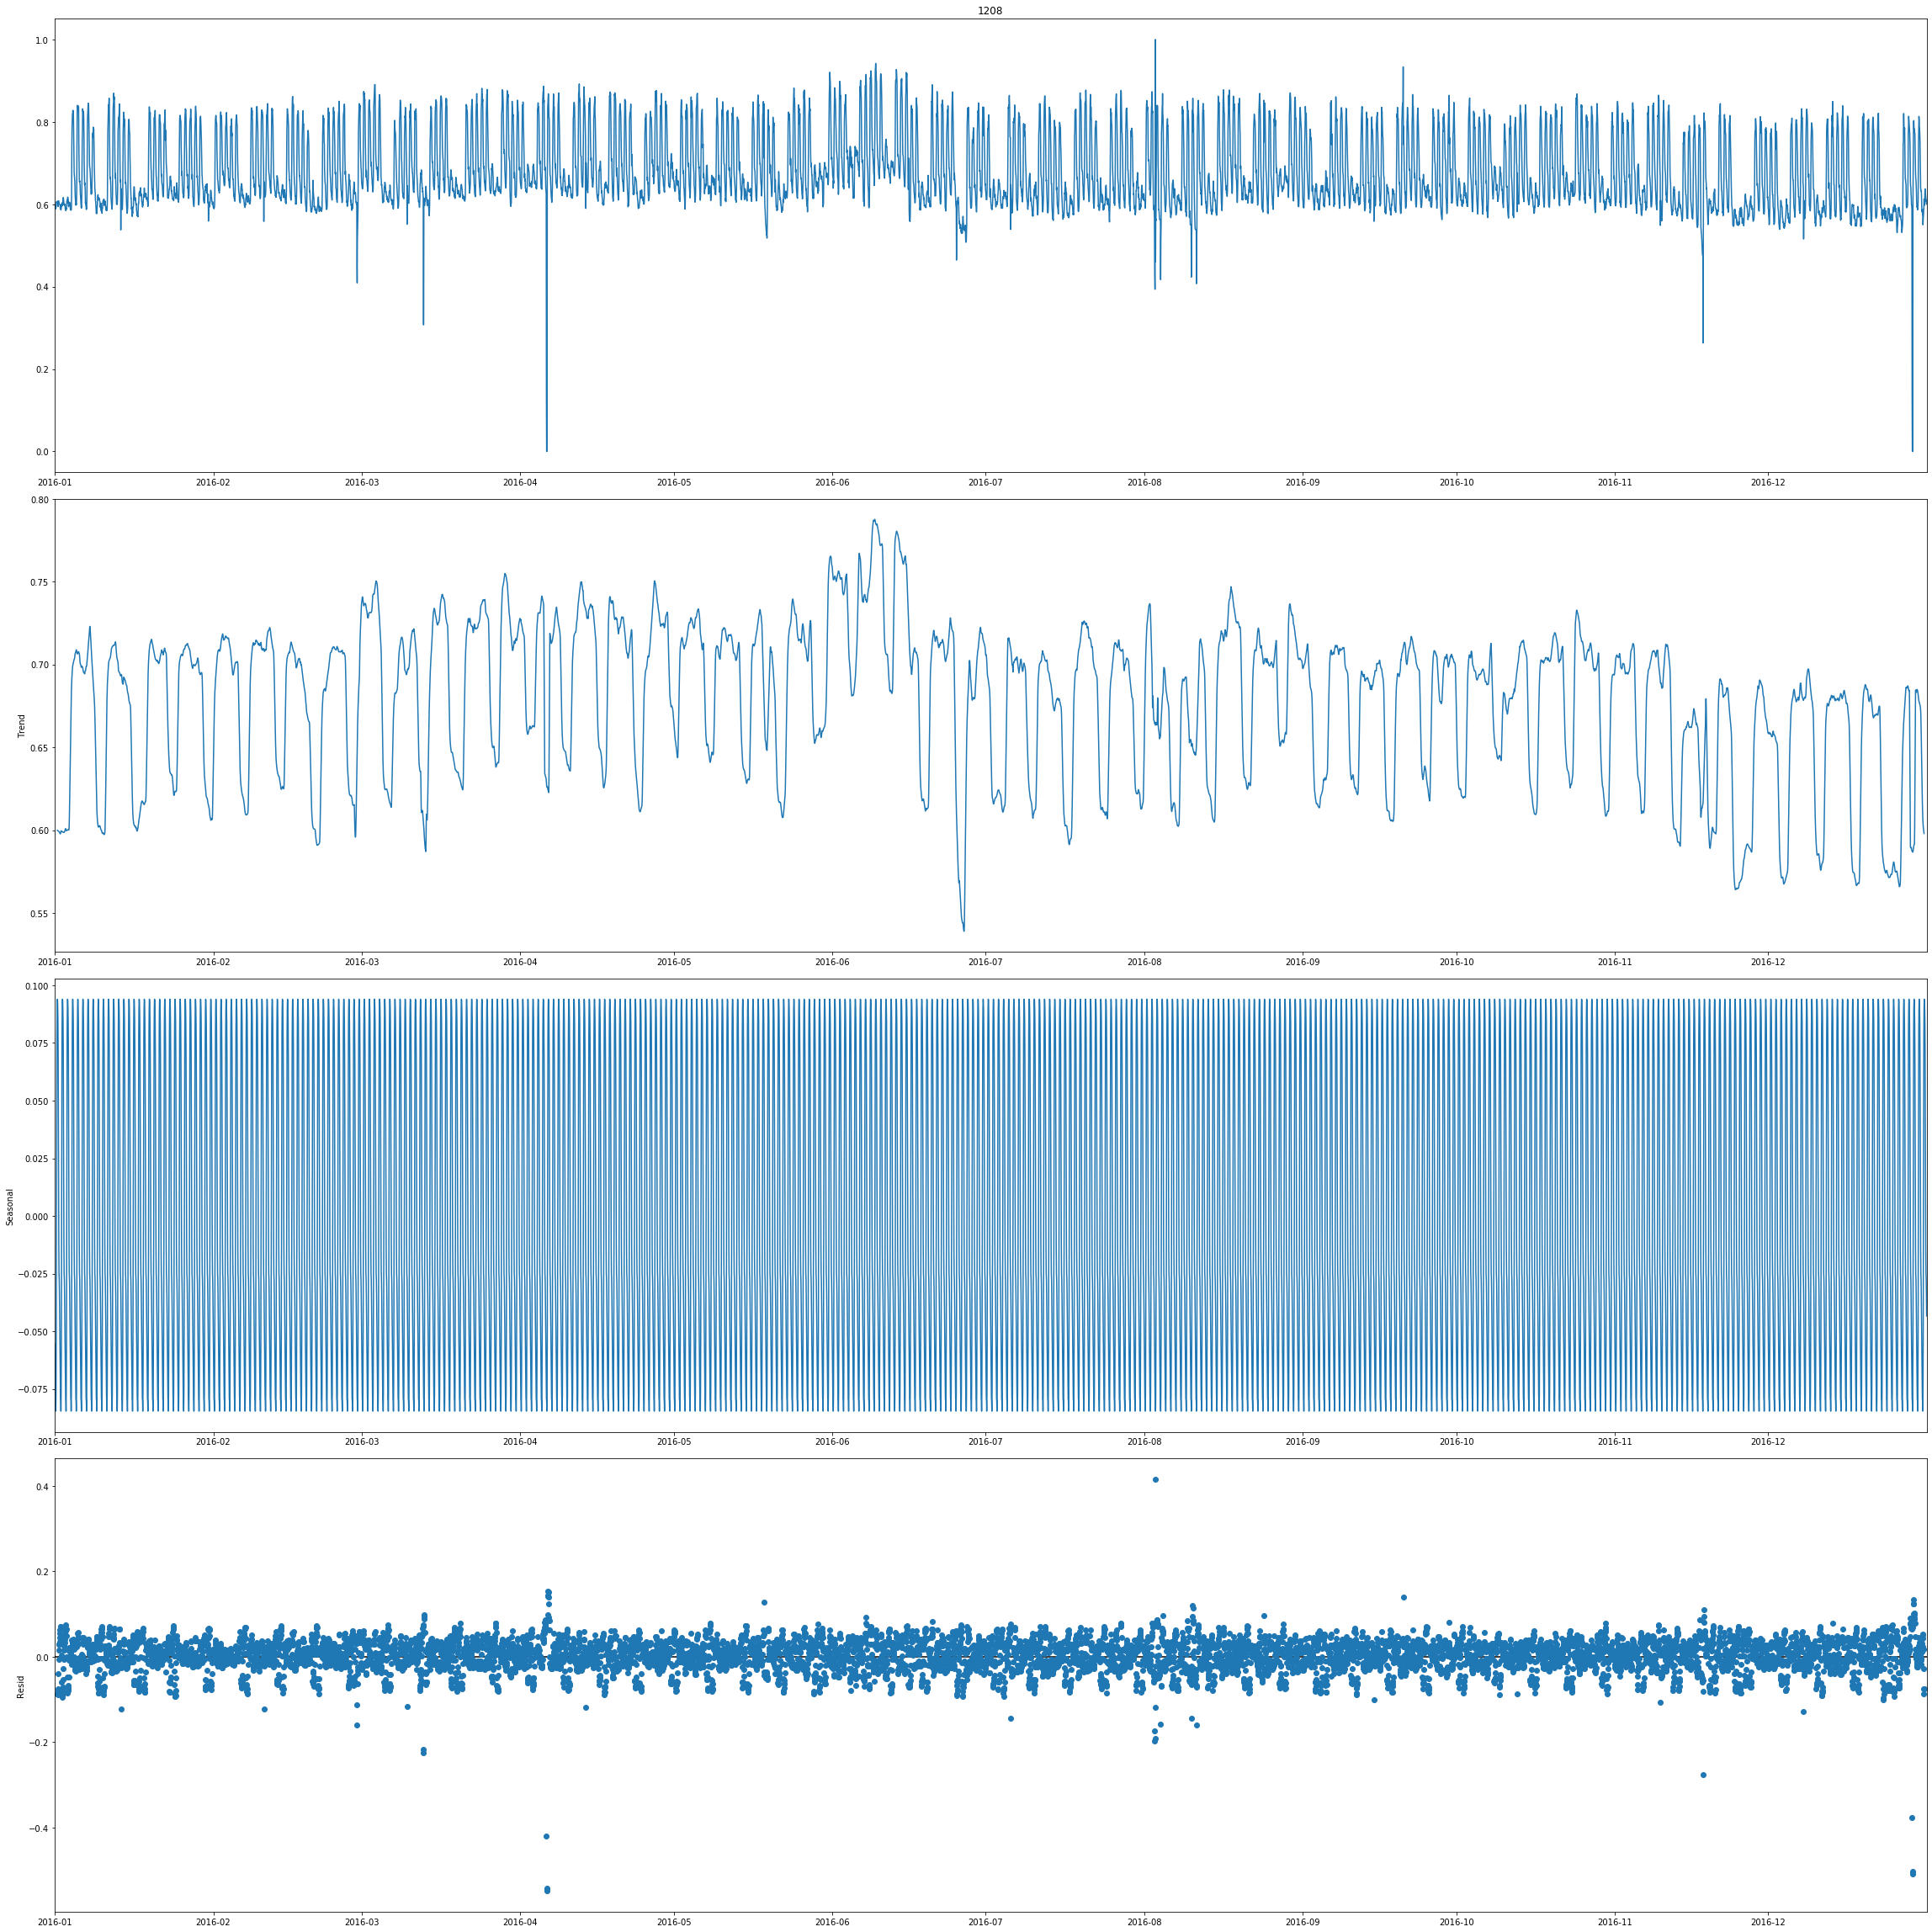

In [164]:
#Performing seasonal decomposition

from pylab import rcParams
rcParams['figure.figsize'] = 32,32
result = sm.tsa.seasonal_decompose(df_transform['meter_reading'][1208], model='additive')
fig = result.plot()
plt.show()

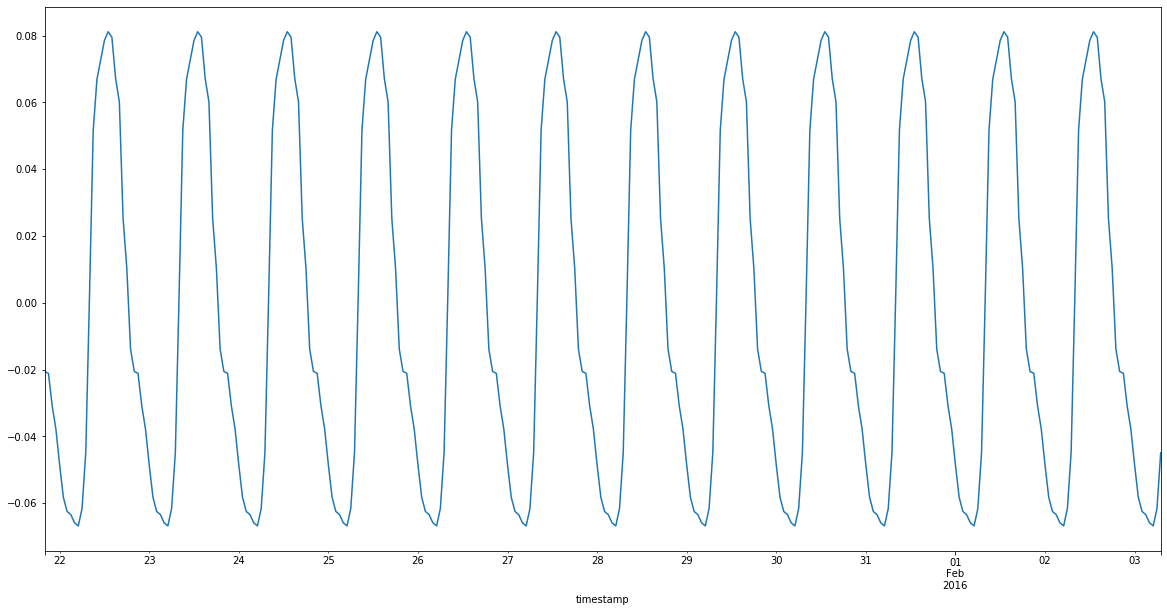

In [165]:
result_zoom = sm.tsa.seasonal_decompose(df_transform['meter_reading'][1208][500:800], model='additive')
result_zoom.seasonal.plot(figsize=(20,10))

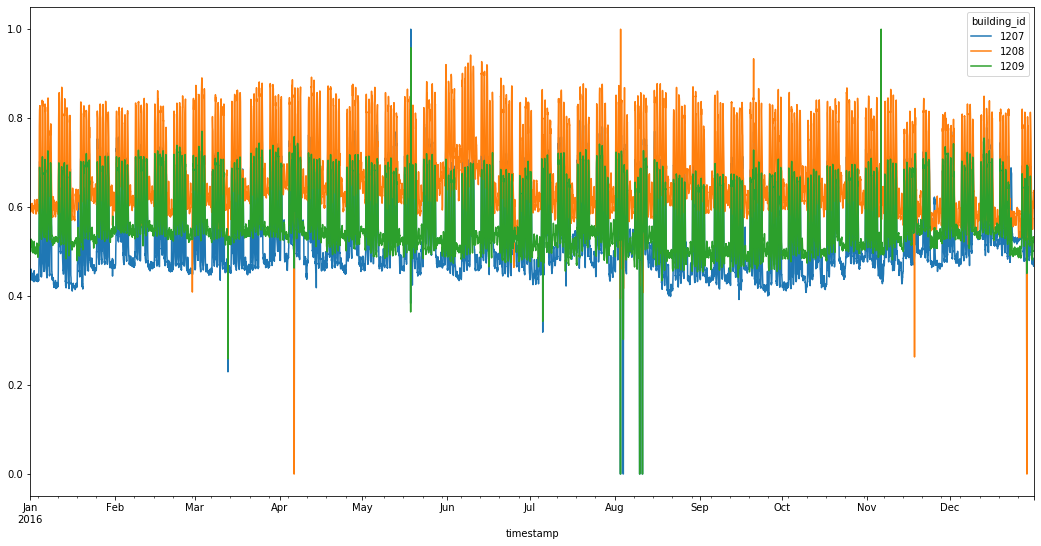

In [166]:
# All data has been scaled!
# Nans permanently replaced via forward filling
df_transform['meter_reading'][[1207,1208,1209]].plot(figsize=(18,9))


# These buildings have very similar behaviour patterns -> very clear seasonality

In [167]:
#auto_arima(df_transform['meter_reading'][1208],seasonal=True,m=24, maxiter=1000, method = 'nm').summary()

In [168]:
#Looking specifically at PACF/ACF
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

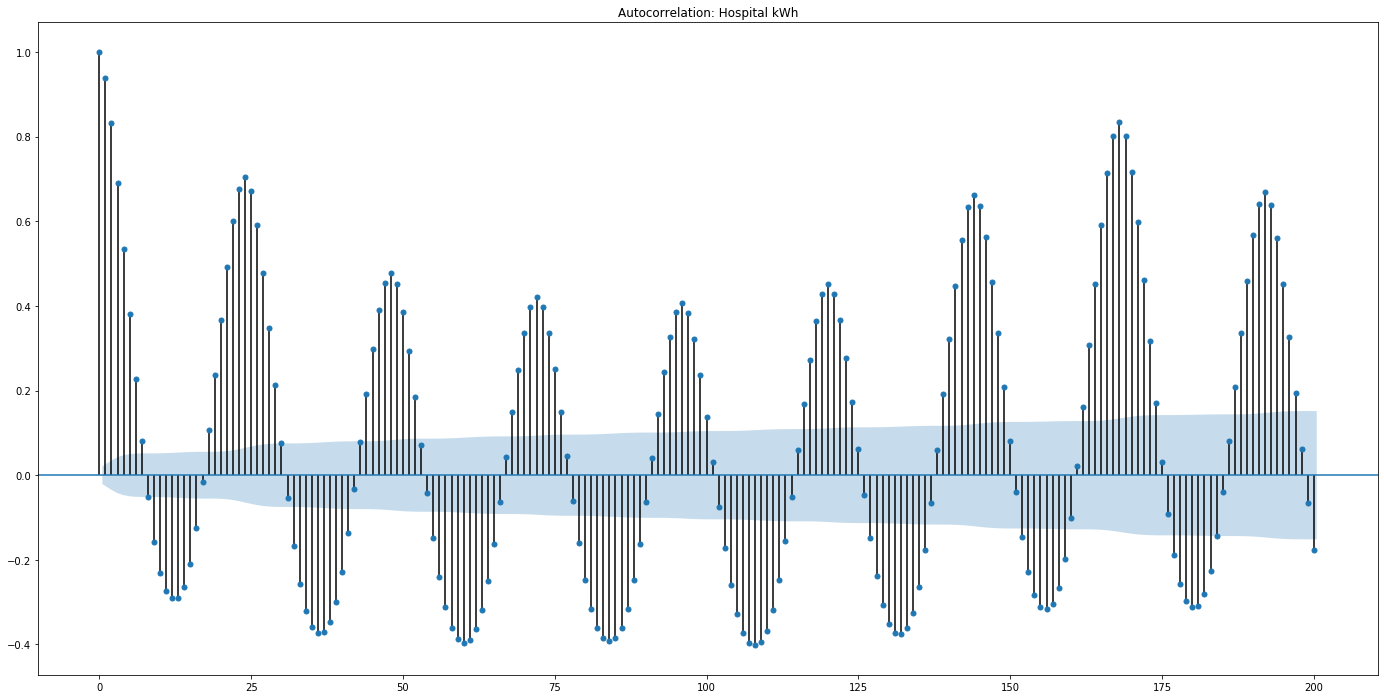

In [169]:
fig, ax = plt.subplots(figsize=(24,12))

lags = 200
plot_acf(df_transform['meter_reading'][1208],ax=ax,lags = lags, title = 'Autocorrelation: Hospital kWh');



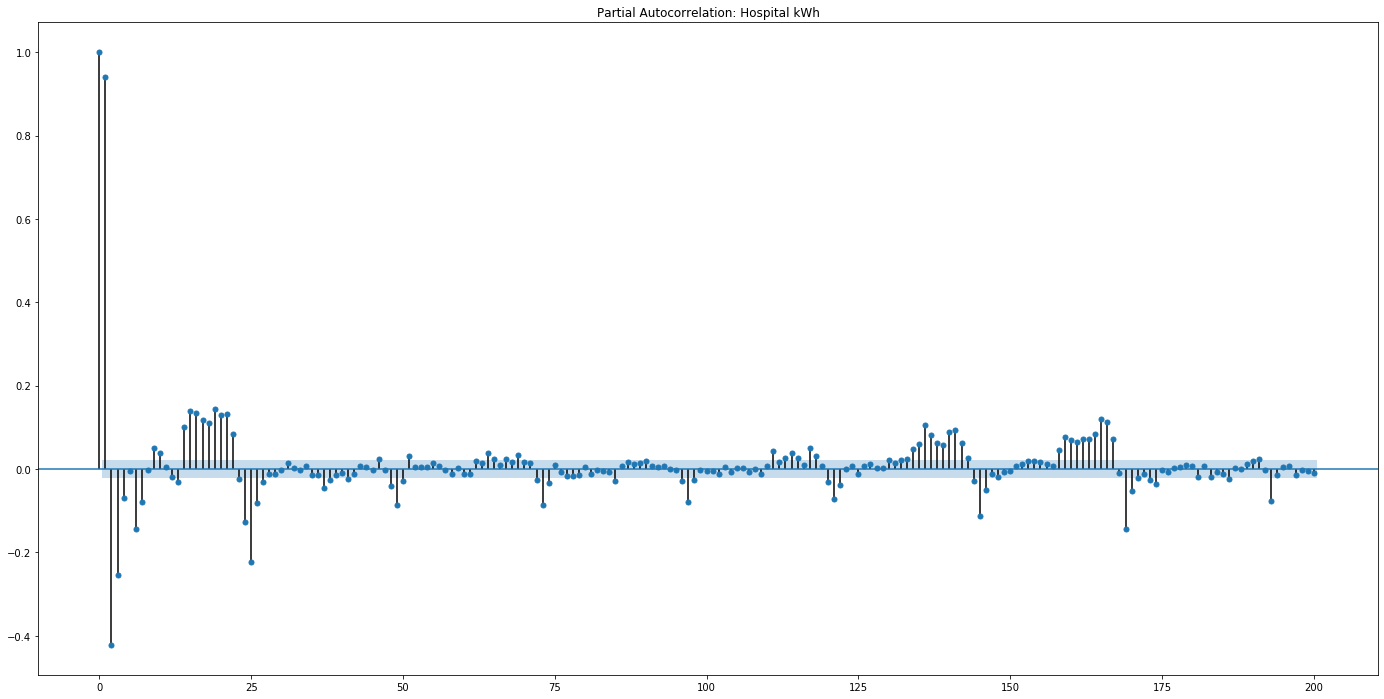

In [170]:
fig, ax = plt.subplots(figsize=(24,12))

lags = 200
plot_pacf(df_transform['meter_reading'][1208],ax=ax,lags = lags, title = 'Partial Autocorrelation: Hospital kWh');



In [171]:
from pmdarima.arima.utils import nsdiffs

In [172]:
D = nsdiffs(df_transform['meter_reading'][1208],
            m=24,  # commonly requires knowledge of dataset
            max_D=24,
            test='ch')

In [173]:
D

1

In [174]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [188]:
'''arma_order_select_ic(df_transform['meter_reading'][1208], ic='aic')'''


"arma_order_select_ic(df_transform['meter_reading'][1208], ic='aic')"

In [ ]:
'''stepwise_fit = pm.auto_arima(df_transform['meter_reading'][1208], start_p=4, start_q=1,m=24,
                             start_P=1,
                             start_Q=2,
                             max_P=4, max_Q=4,
                             d = 0,
                             seasonal=True,
                             D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True,
                             method='nm') '''  # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA(4,0,1)x(1,1,1,24) [intercept=True]; AIC=-39297.335, BIC=-39233.633, Time=69.000 seconds
Fit ARIMA(0,0,0)x(0,1,0,24) [intercept=True]; AIC=-21836.266, BIC=-21822.110, Time=4.607 seconds
Fit ARIMA(1,0,0)x(1,1,0,24) [intercept=True]; AIC=-37588.318, BIC=-37560.006, Time=79.872 seconds
Fit ARIMA(0,0,1)x(0,1,1,24) [intercept=True]; AIC=-30564.688, BIC=-30536.376, Time=75.600 seconds
Fit ARIMA(0,0,0)x(0,1,0,24) [intercept=False]; AIC=-21838.265, BIC=-21831.187, Time=1.612 seconds
Fit ARIMA(4,0,1)x(0,1,1,24) [intercept=True]; AIC=-39583.054, BIC=-39526.430, Time=68.566 seconds
Fit ARIMA(4,0,1)x(0,1,0,24) [intercept=True]; AIC=-36205.623, BIC=-36156.077, Time=24.817 seconds
Fit ARIMA(4,0,1)x(0,1,2,24) [intercept=True]; AIC=-40793.378, BIC=-40729.676, Time=189.726 seconds
Near non-invertible roots for order (4, 0, 1)(0, 1, 2, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(4,0,

In [189]:
#stepwise_fit.summary()

In [88]:
'''
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train,order=(3,0,2),seasonal_order=(1,1,1,24),enforce_invertibility=False)
results = model.fit(maxiter=1000, method='nm')
results.summary()'''

"\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\nmodel = SARIMAX(train,order=(3,0,2),seasonal_order=(1,1,1,24),enforce_invertibility=False)\nresults = model.fit(maxiter=1000, method='nm')\nresults.summary()"

In [89]:
#New train.test split as before

train_1207 = df_transform['meter_reading'][1207].iloc[:7001] 
test_1207 = df_transform['meter_reading'][1207].iloc[7000:]

train_1208 = df_transform['meter_reading'][1208].iloc[:7001] 
test_1208 = df_transform['meter_reading'][1208].iloc[7000:]

train_1209 = df_transform['meter_reading'][1209].iloc[:7001] 
test_1209 = df_transform['meter_reading'][1209].iloc[7000:]

In [181]:
# Previous model -> other workbook
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_1208,order=(3,0,2),seasonal_order=(1,1,1,24),enforce_invertibility=False)
results = model.fit(maxiter=1000, method='nm')
results.summary()

Optimization terminated successfully.
         Current function value: -2.358430
         Iterations: 568
         Function evaluations: 854


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 1208   No. Observations:                 7001
Model:             SARIMAX(3, 0, 2)x(1, 1, [1], 24)   Log Likelihood               16511.366
Date:                              Wed, 17 Jun 2020   AIC                         -33006.732
Time:                                      10:15:17   BIC                         -32951.929
Sample:                                  01-01-2016   HQIC                        -32987.844
                                       - 10-18-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0866      0.061     17.917      0.000       0.968       1.205
ar.L2         -0.5267      0.073     -7.209      0.000      -0.670      -0.384
ar.L3          0.3244      0.053      6.164      0.000       0.221       0.428
ma.L1         -0.1510      0.060     -2.496      0.013      -0.270      -0.032
ma.L2          0.4765      0.051      9.330      0.000       0.376       0.577
ar.S.L24       0.1271      0.006     21.928      0.000       0.116       0.138
ma.S.L24      -1.0102      0.003   -379.865      0.000      -1.015      -1.005
sigma2         0.0005   2.63e-06    189.228      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                      250.14   Jarque-Bera (JB):          12722882.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.99
Prob(H) (two-sided):                  0.69   Kurtosis:                       212.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
# Obtain predicted values
start=len(train_1208)
end=len(train_1208)+len(test_1208)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(4,0,1)(0,0,1,24) Predictions')

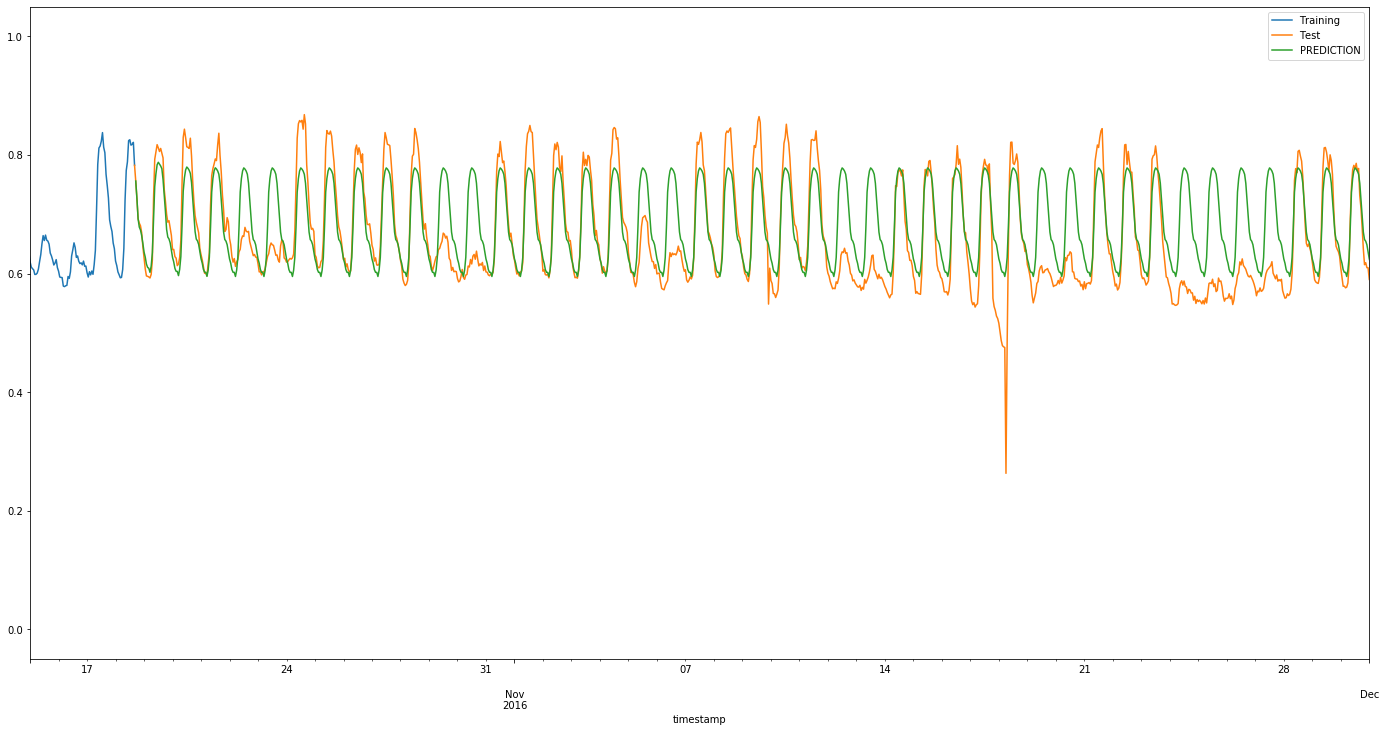

In [184]:
#Initial predictions of train/test split 
train_1208.plot(legend = True, label = 'Training', figsize=(24,12))
test_1208.plot(legend = True, label = 'Test', figsize=(24,12))
predictions.plot(legend=True,label='PREDICTION', xlim=['2016-10-15','2016-12-01 00:00:00']);

In [185]:
# Previous model -> other workbook
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_1207,order=(3,0,2),seasonal_order=(1,1,1,24),enforce_invertibility=False)
results = model.fit(maxiter=1000, method='nm')
results.summary()

/Users/kieranodonnell/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 1207   No. Observations:                 7001
Model:             SARIMAX(3, 0, 2)x(1, 1, [1], 24)   Log Likelihood               15225.360
Date:                              Wed, 17 Jun 2020   AIC                         -30434.719
Time:                                      10:30:40   BIC                         -30379.916
Sample:                                  01-01-2016   HQIC                        -30415.832
                                       - 10-18-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7358      0.143      5.145      0.000       0.455       1.016
ar.L2          0.8133      0.205      3.968      0.000       0.412       1.215
ar.L3         -0.6305      0.075     -8.360      0.000      -0.778      -0.483
ma.L1          0.3125      0.144      2.171      0.030       0.030       0.594
ma.L2         -0.5551      0.061     -9.124      0.000      -0.674      -0.436
ar.S.L24       0.0865      0.003     27.485      0.000       0.080       0.093
ma.S.L24      -1.0140      0.002   -657.829      0.000      -1.017      -1.011
sigma2         0.0007   3.87e-06    184.981      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      504.19   Jarque-Bera (JB):           4681282.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                             3.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       129.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [186]:
# Obtain predicted values
start=len(train_1207)
end=len(train_1207)+len(test_1207)-1
predictions = results.predict(start=start, end=end).rename('SARIMAX(4,0,1)(0,0,1,24) Predictions')

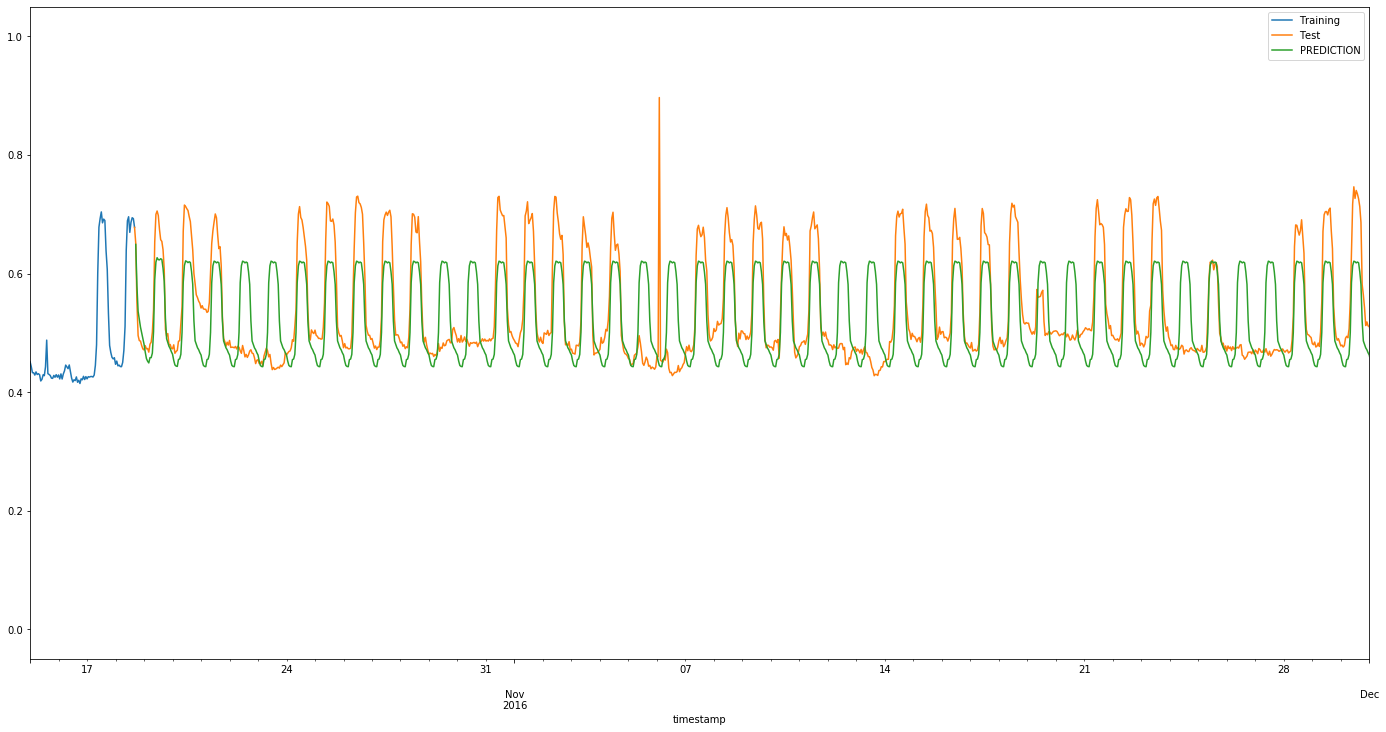

In [187]:
#Initial predictions of train/test split 
train_1207.plot(legend = True, label = 'Training', figsize=(24,12))
test_1207.plot(legend = True, label = 'Test', figsize=(24,12))
predictions.plot(legend=True,label='PREDICTION', xlim=['2016-10-15','2016-12-01 00:00:00']);